In [1]:
import torch 
import torchvision 
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Load MNIST dataset
train_dataset= torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset= torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 1000, shuffle = False)

# Define Models:
### a) Baseline Model ( No Regularization )

In [2]:
import torch.nn as nn 
import torch.nn.functional as F

class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### b) Model with Dropout


In [3]:
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)  # 50% dropout

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


### c) Model with DropConnect
DropConnect involves randomlu dropping individual weights rather than dropping activations. You can simulate DropConnect by multiplying weights by random binary masks during forward passes

In [4]:
class DropConnectNet(nn.Module):
    def __init__(self):
        super(DropConnectNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dropconnect(self.fc1.weight, x, p=0.5)  # DropConnect on fc1
        x = F.relu(x)
        x = self.dropconnect(self.fc2.weight, x, p=0.5)  # DropConnect on fc2
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def dropconnect(self, weights, x, p=0.5):
        # Simulating DropConnect
        mask = torch.bernoulli(torch.full(weights.size(), 1 - p)).to(weights.device)
        return F.linear(x, weights * mask)


# Training the Models

In [5]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

def evaluate(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return test_loss / len(test_loader), accuracy


# Running the Experiments


In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 0.001
epochs = 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Train and evaluate Baseline model
baseline_model = BaselineNet().to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)
train(baseline_model, train_loader, criterion, optimizer, epochs)
baseline_loss, baseline_acc = evaluate(baseline_model, test_loader, criterion)

# Train and evaluate Dropout model
dropout_model = DropoutNet().to(device)
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=learning_rate)
train(dropout_model, train_loader, criterion, optimizer, epochs)
dropout_loss, dropout_acc = evaluate(dropout_model, test_loader, criterion)

# Train and evaluate DropConnect model
dropconnect_model = DropConnectNet().to(device)
optimizer = torch.optim.Adam(dropconnect_model.parameters(), lr=learning_rate)
train(dropconnect_model, train_loader, criterion, optimizer, epochs)
dropconnect_loss, dropconnect_acc = evaluate(dropconnect_model, test_loader, criterion)


Epoch [1/5], Loss: 0.2973
Epoch [2/5], Loss: 0.1344
Epoch [3/5], Loss: 0.0997
Epoch [4/5], Loss: 0.0828
Epoch [5/5], Loss: 0.0679
Epoch [1/5], Loss: 0.5045
Epoch [2/5], Loss: 0.3076
Epoch [3/5], Loss: 0.2610
Epoch [4/5], Loss: 0.2453
Epoch [5/5], Loss: 0.2289
Epoch [1/5], Loss: 0.4356
Epoch [2/5], Loss: 0.2043
Epoch [3/5], Loss: 0.1596
Epoch [4/5], Loss: 0.1420
Epoch [5/5], Loss: 0.1268


# Visualization

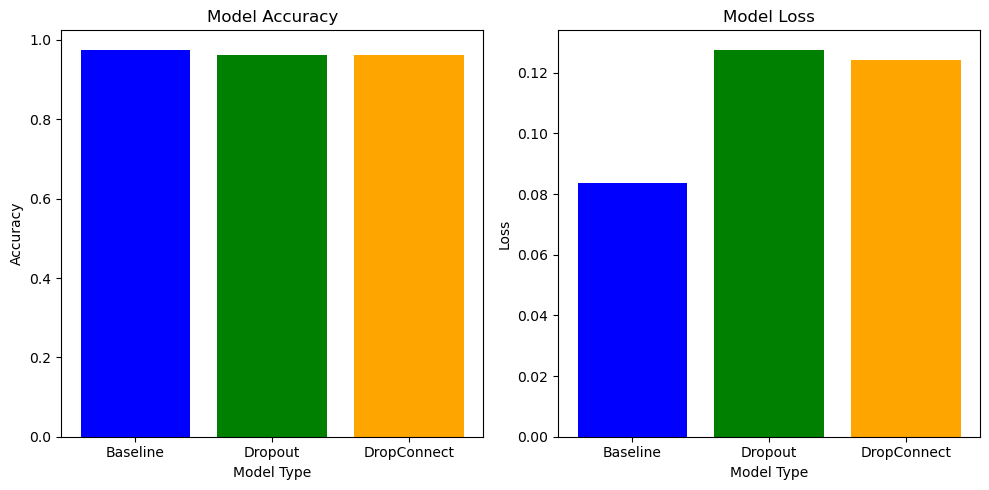

In [7]:
import matplotlib.pyplot as plt

# Visualization of test loss and accuracy
labels = ['Baseline', 'Dropout', 'DropConnect']
losses = [baseline_loss, dropout_loss, dropconnect_loss]
accuracies = [baseline_acc, dropout_acc, dropconnect_acc]

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.bar(labels, losses, color=['blue', 'green', 'orange'])
plt.title('Model Loss')
plt.xlabel('Model Type')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
